In [1]:
!pwd

/home/edolores/NEXTGEMS/tools/HW_contrack


In [2]:
from pyproj import Proj, Transformer, transform, CRS
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
#import xesmf as xe
import matplotlib.patches as mpatches
import glob
import os
import pandas as pd
import time
from itertools import groupby
from scipy.stats import linregress
from contrack import contrack
import cartopy.feature as cfeature

In [3]:
### some functions
def compute_dtr(tx, tn):
    """
    Compute Daily Temperature Range (DTR) as the monthly mean of (TX - TN).

    Parameters:
        tx (xarray.DataArray): Daily maximum temperature (TX), with 'time' dimension.
        tn (xarray.DataArray): Daily minimum temperature (TN), same dimensions as tx.

    Returns:
        xarray.DataArray: Monthly mean daily temperature range.
    """
    # Ensure both inputs align in time and space
    tx, tn = xr.align(tx, tn)

    # Compute daily range
    dtr_daily = tx - tn

    # Compute monthly mean DTR
    dtr_monthly = dtr_daily.resample(time='ME').mean(dim='time', skipna=True)

    # Add metadata
    dtr_monthly.name = 'DTR'
    dtr_monthly.attrs.update({
        'long_name': 'Monthly mean daily temperature range',
        'units': tx.attrs.get('units', '°C'),
        'comment': 'Mean of daily (TX - TN), where TX is max and TN is min temperature.',
        'cell_methods': 'time: mean (of daily max - min)',
    })

    return dtr_monthly


def get_max_dry_spell(seq):
    """
    Get the length of the longest consecutive run of True (dry days) in a 1D boolean array.
    """
    return max((sum(1 for _ in group) for val, group in groupby(seq) if val), default=0)


def compute_CDD(precip, threshold=1.0):
    """
    Compute the maximum length of dry spells (CDD) using groupby logic.
    
    Parameters:
        precip (xarray.DataArray): Daily precipitation with time dim.
        threshold (float): Dry day threshold in mm (default: 1.0).
    
    Returns:
        xarray.DataArray: CDD values (max dry spell length) at each grid point.
    """
    # Get dry day mask
    dry_days = (precip < threshold)

#    dry_days=dry_days.astype(float)

    # Apply the get_max_dry_spell function along 'time' using xarray.apply_ufunc
    cdd = xr.apply_ufunc(
        get_max_dry_spell,
        dry_days,
        input_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int]
    )

    cdd.name = 'CDD'
    cdd.attrs.update({
        'long_name': 'Maximum number of consecutive dry days',
        'units': 'days',
        'comment': 'CDD is the length of the longest dry spell (RR < 1 mm)',
    })

    return cdd,dry_days

# write our own function to get DataArrays with the results
def get_trend(xx: np.ndarray, yy: np.ndarray) -> (xr.DataArray, xr.DataArray, xr.DataArray):
    """Fit linear trend and p-value.

    Parameters
    ----------
    xx : np.ndarray, shape (N,)
    yy : np.ndarray, shape (N,)

    Returns
    -------
    tuple of DataArray : (slope, intercept, pvalue)
    """
    results = linregress(xx, yy, alternative='greater')  # only look for statistically significant positive trends
    return (
        xr.DataArray(results.slope, name='slope'),
        xr.DataArray(results.intercept, name='intercept'),
        xr.DataArray(results.pvalue, name='pvalue'),
    )

# Basic plots

In [43]:
### We load 2 m tempearture daily mean data for the Northern hemisphere 

In [48]:
da=xr.open_mfdataset('/scratch2/edolores/era5/TS_era5/t2m_day_*_0p5deg.nc')['t2m']
da

<xarray.DataArray 't2m' (time: 23741, lat: 181, lon: 720)>
dask.array<concatenate, shape=(23741, 181, 720), dtype=float32, chunksize=(366, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01T11:00:00 ... 2023-12-31T11:00:00
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 0.0 0.5 1.0 1.5 2.0 2.5 ... 88.0 88.5 89.0 89.5 90.0
Attributes:
    long_name:     2 metre temperature
    units:         K
    cell_methods:  time: mean
    institution:   ECMWF

In [49]:
### NH mean time series

In [50]:
era5_month=da.resample(time='1M').mean()
#era5_month.mean(dim=['lat', 'lon']).plot()
era5_month_mean = era5_month.mean(dim=["lat", "lon"]) #.compute()

# 12-month (1 year) rolling mean
#the window length (rolling(time=N)) depending on how much smoothing you want (e.g., 6 for half-year, 24 for 2 years).
era5_smooth = era5_month_mean.rolling(time=12, center=True).mean() #.compute()


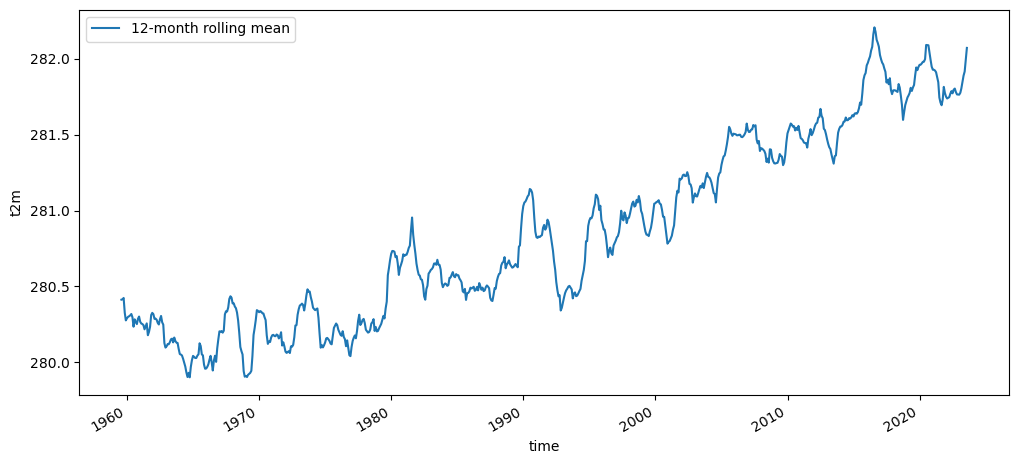

In [51]:
# Plot both raw monthly and smoothed
plt.figure(figsize=(12,5))
#era5_month_mean.plot(label="Monthly mean")
era5_smooth.plot(label="12-month rolling mean")
plt.legend()
plt.show()

In [14]:
### NH map mean

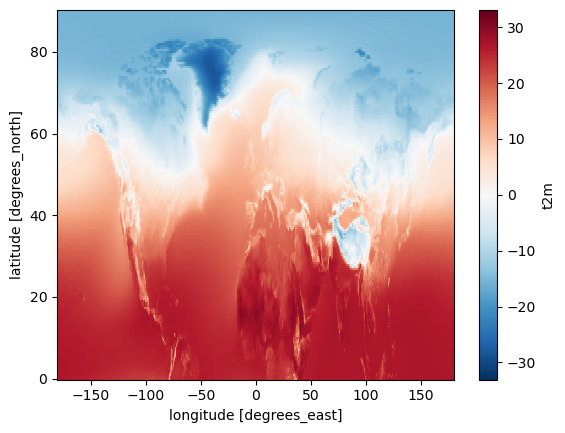

In [15]:
(era5_month-273.15).mean(dim=['time']).plot()

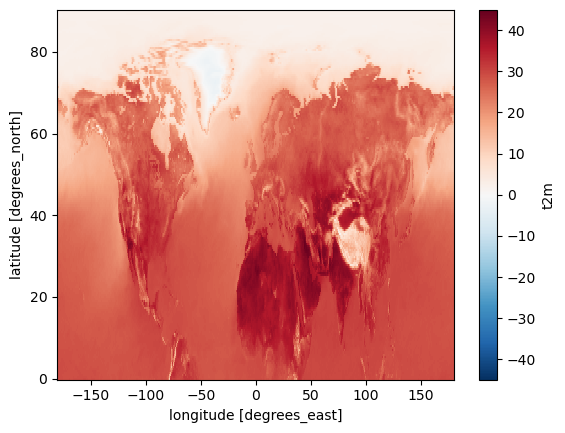

In [16]:
### max daily mean
(da-273.15).max(dim=['time']).plot()

In [17]:
### mean yearly
temp_year=era5_month.resample(time='1Y').mean()
temp_year
# Convert time to float years
time_in_years = temp_year['time'].dt.year + (temp_year['time'].dt.dayofyear - 1) / 365.25
print(time_in_years)

results = xr.apply_ufunc(
    get_trend,
    time_in_years, temp_year.compute(),
#    temp_year['time'], temp_year,
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[], [], []],
    vectorize=True,
)


ds = xr.Dataset(
    {'slope': results[0],
     'intercept': results[1],
     'pvalue': results[2],
    })
ds

<xarray.DataArray (time: 41)>
array([1959.99657769, 1960.99931554, 1961.99657769, 1962.99657769,
       1963.99657769, 1964.99931554, 1965.99657769, 1966.99657769,
       1967.99657769, 1968.99931554, 1969.99657769, 1970.99657769,
       1971.99657769, 1972.99931554, 1973.99657769, 1974.99657769,
       1975.99657769, 1976.99931554, 1977.99657769, 1978.99657769,
       1979.99657769, 1980.99931554, 1981.99657769, 1982.99657769,
       1983.99657769, 1984.99931554, 1985.99657769, 1986.99657769,
       1987.99657769, 1988.99931554, 1989.99657769, 1990.99657769,
       1991.99657769, 1992.99931554, 1993.99657769, 1994.99657769,
       1995.99657769, 1996.99931554, 1997.99657769, 1998.99657769,
       1999.99657769])
Coordinates:
  * time     (time) datetime64[ns] 1959-12-31 1960-12-31 ... 1999-12-31


<xarray.Dataset>
Dimensions:    (lon: 720, lat: 181)
Coordinates:
  * lon        (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat        (lat) float32 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
Data variables:
    slope      (lat, lon) float64 0.006858 0.006743 0.006496 ... 0.06807 0.06807
    intercept  (lat, lon) float64 286.4 286.6 287.1 287.6 ... 123.0 123.0 123.0
    pvalue     (lat, lon) float64 0.08074 0.08823 ... 4.673e-06 4.673e-06

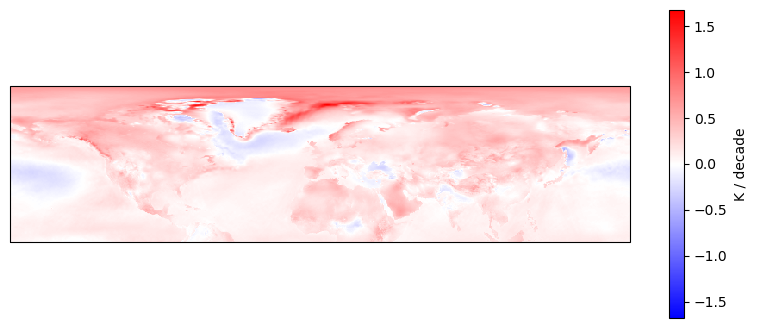

In [18]:
fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})
(ds['slope'] * 10).plot.pcolormesh(ax=ax, cmap='bwr', cbar_kwargs={'label': 'K / decade'})

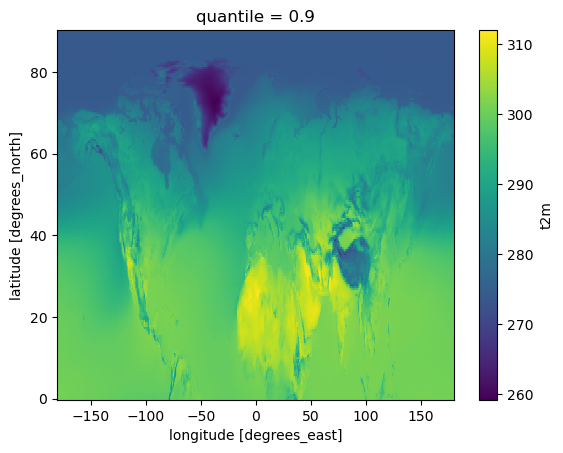

In [19]:
### percentiles
ds1 = da.chunk({"time": -1})
q90 = ds1.quantile(0.9, dim="time")
q90.plot()

In [20]:
### Mask to count days above the 20 (tropical nights) --> This should be minimum temperature
temp_mask = ((da-273.15) > 20).compute() # gives true and false values (which is our mask)
#temp_mask.compute()

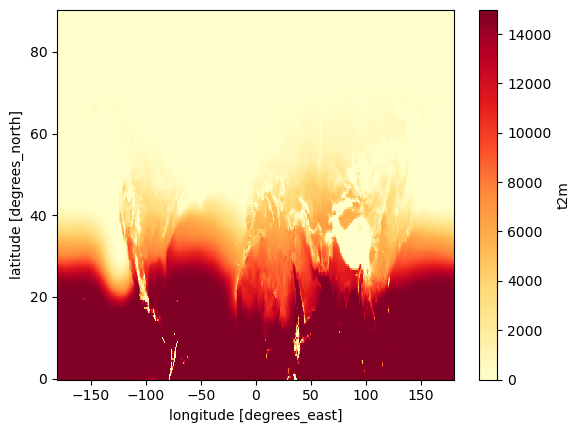

In [21]:
# Counting the days and plotting
temp_mask.sum(dim=["time"]).plot(
    cmap='YlOrRd'#, levels=np.arange(0, 200, 20)
)  # Sum up True values and plot the result

# Tracking heatwaves

In [3]:
### Preparing data to track heatwaves

In [6]:
#Get full dataset
inpath='/scratch2/edolores/era5/T850_era5/' # '/scratch2/edolores/era5/TS_era5/'
fvar='t850' #t2m
dvar='t' #t2m
temp = xr.open_mfdataset(inpath+'/'+fvar+'_day_*_0p5deg.nc', chunks={"time": 365, "lon": -1, "lat": -1})[dvar]
temp

<xarray.DataArray 't' (time: 23375, level: 1, lat: 181, lon: 720)>
dask.array<concatenate, shape=(23375, 1, 181, 720), dtype=float32, chunksize=(365, 1, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01T09:00:00 ... 2022-12-31T09:00:00
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 0.0 0.5 1.0 1.5 2.0 2.5 ... 88.0 88.5 89.0 89.5 90.0
  * level    (level) float64 850.0
Attributes:
    standard_name:  air_temperature
    long_name:      Temperature
    units:          K
    cell_methods:   time: mean
    institution:    ECMWF

In [7]:
### selecting years
#dERA5 = pd.date_range(start="1959-01-01",end="2024-12-31")
dERA5 = pd.date_range(start="1959-01-01",end="2023-12-31")

### selecting months around summer (JJA)
dERA5 = dERA5[dERA5.month.isin([4, 5, 6, 7, 8, 9, 10])]

doyVec = pd.to_numeric(dERA5.strftime('%j'))

matExt = temp*0 ### replace name df

start = time.perf_counter()

'''
### This produce an error of mistmatch!:
print('calculating anomalies on moving 30-day 8-year moving window')

for tt in range(temp.time.size):
    print(tt)
    #30 day 8-year rolling window
    vec = (abs(doyVec-doyVec[tt])<=15)*(abs(dERA5-dERA5[tt])<='1475 days')
    matExt[tt,:,:] = (temp[tt,:,:] - temp[vec,:,:].mean('time'))/ temp[vec,:,:].std('time') ##standarized temperature
    
print('write anomalies to netcdf')
matExt = matExt.sel(time=matExt.time.dt.month.isin([5,6,7,8,9]))
matExt
'''

"\n### This produce an error of mistmatch!:\nprint('calculating anomalies on moving 30-day 8-year moving window')\n\nfor tt in range(temp.time.size):\n    print(tt)\n    #30 day 8-year rolling window\n    vec = (abs(doyVec-doyVec[tt])<=15)*(abs(dERA5-dERA5[tt])<='1475 days')\n    matExt[tt,:,:] = (temp[tt,:,:] - temp[vec,:,:].mean('time'))/ temp[vec,:,:].std('time') ##standarized temperature\n    \nprint('write anomalies to netcdf')\nmatExt = matExt.sel(time=matExt.time.dt.month.isin([5,6,7,8,9]))\nmatExt\n"

In [8]:
#print(len(dERA5) ,temp.time.size)
#dERA5

In [9]:
#tt=0
#vec=(abs(doyVec-doyVec[tt])<=15)*(abs(dERA5-dERA5[tt])<='1475 days')
##doyVec-doyVec[tt]
#vec
#temp[vec,:,:]

In [11]:
###
#len(vec)

In [12]:
### version two (it took 2 hours to cover 40 years)

In [ ]:
# 1) Make sure temp is sliced to the same dates & months as you intend
temp = temp.sel(time=slice("1959-01-01", "2023-12-31"))
temp = temp.sel(time=temp["time.month"].isin([4,5,6,7,8,9,10]))

# 2) Prepare vectors from temp.time so lengths match
t = temp.time
doy = t.dt.dayofyear

# (optional) preallocate output with same shape
matExt = xr.zeros_like(temp)

print('calculating anomalies on moving 30-day 8-year moving window')

# helper for circular day-of-year difference (handles year wrap cleanly)
def circ_doy_diff(a, b):
    # a, b are numpy arrays or scalars of day-of-year (1..366)
    d = np.abs(a - b)
    return np.minimum(d, 365 - d)

for tt in range(t.size):
    # 30-day window (±15 days) using circular DOY difference
    w_doy = circ_doy_diff(doy.values, doy.values[tt]) <= 15

    # 8-year window centered on time[tt] → ±1475 days (~8.08 years total width)
    w_time = np.abs((t.values - t.values[tt]).astype('timedelta64[D]')) <= np.timedelta64(1475, 'D')

    # combine masks (both are boolean arrays with length == t.size)
    vec = w_doy & w_time

    # compute standardized anomalies
    clim = temp.isel(time=vec).mean('time')
    std  = temp.isel(time=vec).std('time')

    # avoid division by zero if any std == 0
    matExt[tt, :, :] = xr.where(std > 0, (temp.isel(time=tt) - clim) / std, np.nan)

calculating anomalies on moving 30-day 8-year moving window


In [ ]:
print('select months')
matExt = matExt.sel(time=matExt.time.dt.month.isin([5,6,7,8,9])).compute()
matExt

In [ ]:
#matExt.isel(time=300).plot()
print('write anomalies to netcdf')
matExt.to_netcdf(inpath+'/ERA5_'+fvar+'_NH_19592023_AMJJASO_daily_MA.nc')
#matExt[:,100,0].plot()
#matExt_month=matExt.resample(time='1M').mean()
#matExt_month.mean(dim=['lat', 'lon']).plot()

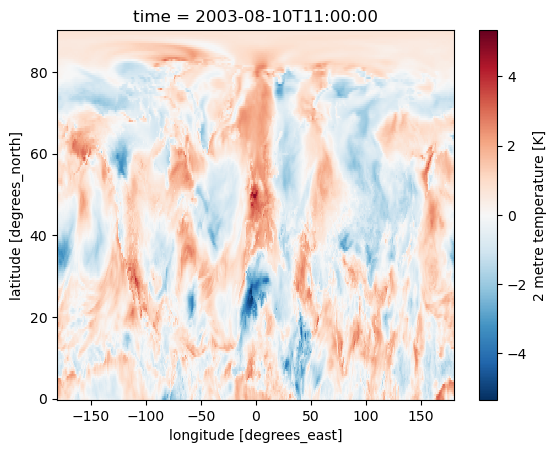

In [15]:
snap=matExt.sel(time='2003-08-10',drop=True)
snap.plot()

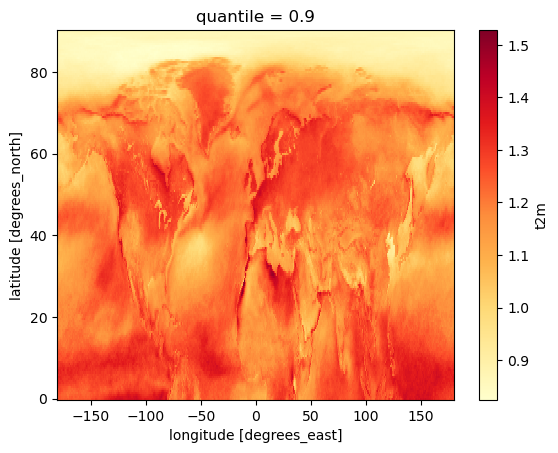

In [16]:
q90 =matExt.quantile(0.9, dim="time")
q90.plot(cmap='YlOrRd')

In [17]:
### specific day showing regions above the 90th percentile 

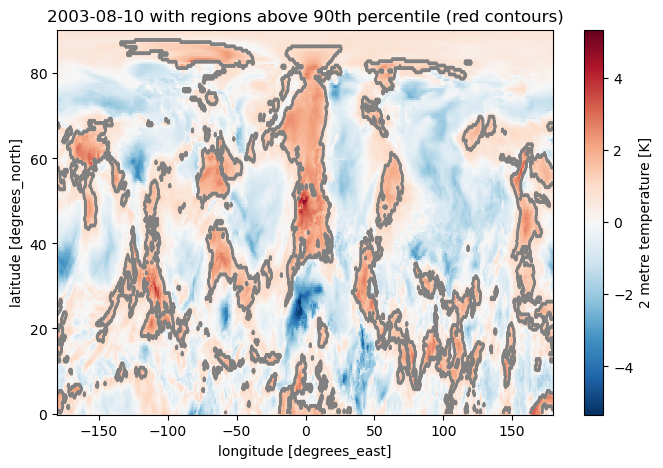

In [21]:
# Start plot of the field
fig, ax = plt.subplots(figsize=(8, 5))
snap.plot(ax=ax, cmap="RdBu_r")  # base field

# Overlay contour line(s) where values exceed q90
(snap.isel(time=0) > q90).plot.contour(ax=ax, colors="grey", linewidths=1.5)

plt.title("2003-08-10 with regions above 90th percentile (red contours)")
plt.show()

In [22]:
##### Smoothing spatially

In [23]:
##### Save binary files 1/0

In [24]:
binary=xr.where ( matExt> q90, 1, 0)

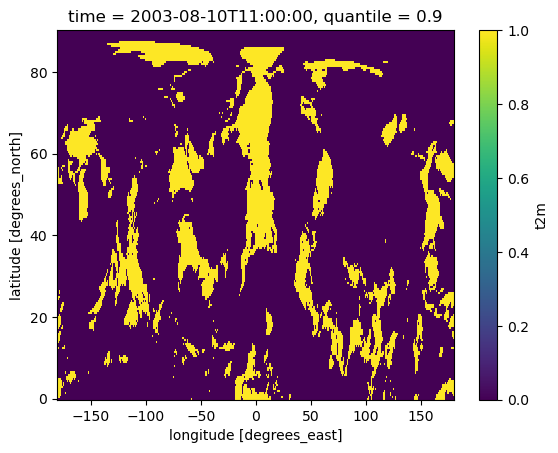

In [27]:
binary.sel(time='2003-08-10',drop=True).plot()

In [28]:
### Track heatwaves
#anom

In [31]:
### intitate
anom = contrack()
anom.read_xarray(binary.to_dataset())

anom.set_up(force=True)
anom.ds=anom.ds.compute()

            Hint: use set_up(force=True).
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'



In [32]:
# Finally, track temperature anomalies (>=1, 50% overlap twosided, 3 timesteps persistence (here 3 days))
anom.run_contrack(variable='t2m',
                   threshold=1,
                   gorl='>=',
                   overlap=0.5,
                   persistence=3,
                   twosided=True)

INFO: 
Run ConTrack 
########### 
    threshold:    >= 1 
    overlap:      0.5 
    persistence:  3 time steps
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

INFO: Find individual contours...
INFO: Create new variable 'flag'...
INFO: Running contrack... DONE
13340 contours tracked


In [40]:
### save blobs 
#anom.to_netcdf('/scratch2/edolores/era5/Heatwaves/MA_TS/HW_ERA5_NH_19592023_AMJJASO_daily_MA.nc')

### lifecycle
#anom_df = anom.run_lifecycle(flag='flag', variable='t2m')
#anom_df.to_csv('/scratch2/edolores/era5/Heatwaves/MA_TS/HW_ERA5_NH_19592023_AMJJASO_daily_MA.csv', index=False)

In [34]:
###Frequency
mean_hw = xr.where(anom['flag']>1,1,0).mean(dim='time')*100
#mean_hw.plot(cmap='YlOrRd', levels=np.arange(0, 5, 0.5))

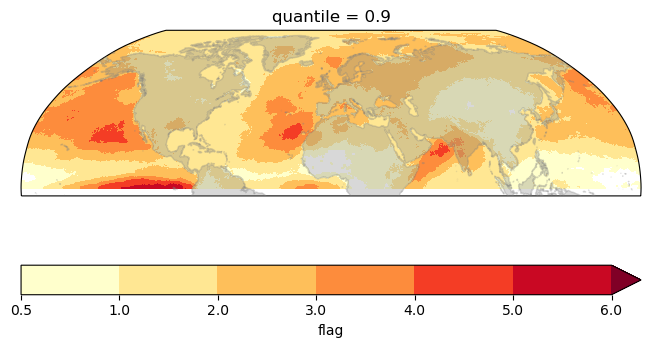

In [51]:
proj = ccrs.Robinson(central_longitude=0, globe=None)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})
plot=mean_hw.plot(ax=ax1, cmap='YlOrRd', levels=[0.5,1,2,3,4,5,6],transform=ccrs.PlateCarree(),extend="max",cbar_kwargs={"orientation":"horizontal"})
# Add features
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)

In [41]:
# output is a pandas.DataFrame
print(anom_df)
anom_df['Longitude2'] = np.where(anom_df['Longitude'] < 0, anom_df['Longitude']+360,anom_df['Longitude'])

          Flag         Date  Longitude  Latitude  Intensity        Size
0          136  19590501_11       -102        42        1.0  2632644.17
1          136  19590502_11        -97        42        1.0  2360040.69
2          136  19590503_11        -90        40        1.0  2636247.45
3          136  19590504_11        -90        39        1.0  1674758.86
4          136  19590505_11        -89        41        1.0  1310003.64
...        ...          ...        ...       ...        ...         ...
54019  1322861  20230929_11        -73        51        1.0     1938.46
54020  1322861  20230930_11        -74        51        1.0     3876.93
54021  1322862  20230928_11         30        51        1.0     1938.46
54022  1322862  20230929_11         41        62        1.0    12713.37
54023  1322862  20230930_11         35        62        1.0  2902228.71

[54024 rows x 6 columns]


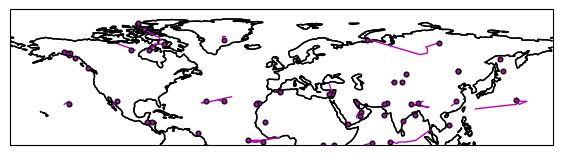

In [48]:
# plotting blocking track (center of mass) and genesis
#f, ax = plt.subplots(1, 1, figsize=(7,5), subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
f, ax = plt.subplots(1, 1, figsize=(7,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree()); ax.coastlines()
ax.coastlines() # add coastlines
#need to split each blocking track due to longitude wrapping (jumping at map edge)
for bid in np.unique(np.asarray(anom_df['Flag'][12000:12200])): #select blocking id
    lons = np.asarray(anom_df['Longitude2'].iloc[np.where(anom_df['Flag']==bid)])
    lats = np.asarray(anom_df['Latitude'].iloc[np.where(anom_df['Flag']==bid)])

    # cosmetic: sometimes there is a gap near map edge where track is split:
    lons[lons >= 355] = 359.9
    lons[lons <= 3] = 0.1
    segment = np.vstack((lons,lats))

    #move longitude into the map region and split if longitude jumps by more than "threshold"
    lon0 = 0 #center of map
    bleft = lon0-0.
    bright = lon0+360
    segment[0,segment[0]> bright] -= 360
    segment[0,segment[0]< bleft]  += 360
    threshold = 180  # CHANGE HERE
    isplit = np.nonzero(np.abs(np.diff(segment[0])) > threshold)[0]
    subsegs = np.split(segment,isplit+1,axis=+1)

    #plot the tracks
    for seg in subsegs:
        x,y = seg[0],seg[1]
        ax.plot(x ,y,c = 'm',linewidth=1, transform=ccrs.PlateCarree())
    #plot the starting points
    ax.scatter(lons[0],lats[0],s=11,c='m', zorder=10, edgecolor='black', transform=ccrs.PlateCarree())

In [109]:
### Using T850 as well

In [ ]:
### Southern hemisphere / traditional heatwave definition